In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix as sk_confusion_matrix

In [5]:
def load_data():
    """Load pre-extracted features and labels."""
    print("Loading data...")
    X = np.load('X_features.npy')
    y = np.load('y_labels.npy')
    print(f"Data loaded. Features shape: {X.shape}, Labels shape: {y.shape}")
    return X, y

In [6]:
def standardize_features(X_train, X_val=None, X_test=None):
    """Standardize features to have zero mean and unit variance."""
    # Remove features with near-zero variance
    variances = np.var(X_train, axis=0)
    good_variance_indices = variances > 1e-10

    print(f"Removing {np.sum(~good_variance_indices)} low-variance features")
    X_train_filtered = X_train[:, good_variance_indices]

    # Calculate mean and std
    mean = np.mean(X_train_filtered, axis=0)
    std = np.std(X_train_filtered, axis=0)
    std[std < 1e-10] = 1.0

    X_train_std = (X_train_filtered - mean) / std
    result = [X_train_std]

    if X_val is not None:
        X_val_std = (X_val[:, good_variance_indices] - mean) / std
        result.append(X_val_std)

    if X_test is not None:
        X_test_std = (X_test[:, good_variance_indices] - mean) / std
        result.append(X_test_std)

    return result if len(result) > 1 else result[0], good_variance_indices

In [7]:
def reduce_dimensionality_pca(X_train, X_val=None, X_test=None, n_components=100):
    """Simple PCA implementation to reduce dimensionality"""
    # Center the data
    mean = np.mean(X_train, axis=0)
    X_centered = X_train - mean

    # Calculate covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Calculate eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]

    # Select top n_components eigenvectors
    components = eigenvectors[:, :n_components]

    # Project data onto components
    X_train_pca = X_centered @ components

    result = [X_train_pca]

    if X_val is not None:
        X_val_pca = (X_val - mean) @ components
        result.append(X_val_pca)

    if X_test is not None:
        X_test_pca = (X_test - mean) @ components
        result.append(X_test_pca)

    return result if len(result) > 1 else result[0]

In [8]:
class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eig_vectors = None
        self.mean = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)
        n_classes = len(unique_classes)

        if self.n_components is None:
            self.n_components = min(n_features, n_classes - 1)

        # Overall mean
        self.mean = np.mean(X, axis=0)

        # Calculate scatter matrices
        Sw = np.zeros((n_features, n_features))  # Within-class scatter
        Sb = np.zeros((n_features, n_features))  # Between-class scatter

        for c in unique_classes:
            X_c = X[y == c]
            n_c = X_c.shape[0]
            mean_c = np.mean(X_c, axis=0)

            # Within-class scatter
            X_centered = X_c - mean_c
            Sw += X_centered.T @ X_centered

            # Between-class scatter
            mean_diff = (mean_c - self.mean).reshape(-1, 1)
            Sb += n_c * mean_diff @ mean_diff.T

        # Add regularization
        Sw += np.eye(n_features) * 1e-3 * np.trace(Sw) / n_features

        # Calculate eigenvectors
        try:
            Sw_inv = np.linalg.inv(Sw)
            matrix_to_decompose = Sw_inv @ Sb
            matrix_sym = (matrix_to_decompose + matrix_to_decompose.T) / 2
            eigen_values, eigen_vectors = np.linalg.eigh(matrix_sym)

            # Sort in descending order
            idx = np.argsort(eigen_values)[::-1]
            eigen_values = eigen_values[idx]
            eigen_vectors = eigen_vectors[:, idx]

        except np.linalg.LinAlgError:
            print("Warning: Using SVD for LDA decomposition")
            u, s, vh = np.linalg.svd(Sw)
            tol = s.max() * 1e-3
            s_inv = np.zeros_like(s)
            s_inv[s > tol] = 1/s[s > tol]

            Sw_inv = vh.T @ np.diag(s_inv) @ u.T
            eigen_values, eigen_vectors = np.linalg.eigh(Sw_inv @ Sb)

            idx = np.argsort(eigen_values)[::-1]
            eigen_values = eigen_values[idx]
            eigen_vectors = eigen_vectors[:, idx]

        # Store the top eigenvectors
        self.eig_vectors = eigen_vectors[:, :self.n_components]

        # Calculate explained variance
        explained_variance = eigen_values[:self.n_components] / np.sum(eigen_values)
        print(f"LDA explained variance: {np.sum(explained_variance):.4f}")
        return self

    def transform(self, X):
        if self.eig_vectors is None:
            raise ValueError("LDA model not fitted yet.")
        return X @ self.eig_vectors

In [9]:
class DecisionTreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, gain=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.gain = gain

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='entropy', class_weight=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.class_weight = class_weight
        self.root = None
        self.feature_importances_ = None

    def fit(self, X, y):
        # Handle missing values
        X = np.nan_to_num(X)

        # Compute class weights
        if self.class_weight == 'balanced':
            class_counts = Counter(y)
            n_samples = len(y)
            self.sample_weights = np.ones(n_samples)
            for i, label in enumerate(y):
                self.sample_weights[i] = n_samples / (len(class_counts) * class_counts[label])
        else:
            self.sample_weights = np.ones(len(y))

        # Setup feature tracking
        self.n_features = X.shape[1]
        self.classes_ = np.unique(y)
        self.feature_importances_ = np.zeros(self.n_features)
        self.feature_indices_ = np.arange(self.n_features)

        # Grow the tree
        self.root = self._grow_tree(X, y, self.sample_weights)

        # Normalize feature importance
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)

        return self

    def _grow_tree(self, X, y, sample_weights, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Check stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth or
                n_samples < self.min_samples_split or
                n_classes == 1):
            leaf_value = self._weighted_most_common_label(y, sample_weights)
            return DecisionTreeNode(value=leaf_value)

        # Find the best split
        best_feature, best_threshold, best_gain = self._best_split(X, y, sample_weights)

        # If no good split is found
        if best_feature is None:
            leaf_value = self._weighted_most_common_label(y, sample_weights)
            return DecisionTreeNode(value=leaf_value)

        # Create child nodes
        left_indices = X[:, best_feature] < best_threshold
        right_indices = ~left_indices

        # Check if split would create valid leaves
        if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
            leaf_value = self._weighted_most_common_label(y, sample_weights)
            return DecisionTreeNode(value=leaf_value)

        # Recursively grow subtrees
        left_subtree = self._grow_tree(
            X[left_indices], y[left_indices], sample_weights[left_indices], depth + 1
        )
        right_subtree = self._grow_tree(
            X[right_indices], y[right_indices], sample_weights[right_indices], depth + 1
        )

        # Update feature importance
        self.feature_importances_[best_feature] += best_gain * n_samples

        return DecisionTreeNode(
            feature_index=best_feature,
            threshold=best_threshold,
            left=left_subtree,
            right=right_subtree,
            gain=best_gain
        )

    def _best_split(self, X, y, sample_weights):
        best_gain = 0
        best_feature = None
        best_threshold = None

        # Calculate base impurity
        if self.criterion == 'entropy':
            base_impurity = self._weighted_entropy(y, sample_weights)
        else:  # 'gini'
            base_impurity = self._weighted_gini(y, sample_weights)

        # Try each feature
        for feature_idx in range(self.n_features):
            feature_values = X[:, feature_idx]

            # Skip features with insufficient valid values
            valid_indices = np.isfinite(feature_values)
            if np.sum(valid_indices) <= 1:
                continue

            valid_values = feature_values[valid_indices]
            unique_values = np.unique(valid_values)

            # Skip features with only one unique value
            if len(unique_values) <= 1:
                continue

            # Determine thresholds to try
            if len(unique_values) > 10:
                percentiles = np.linspace(10, 90, 10)
                thresholds = np.percentile(valid_values, percentiles)
            else:
                thresholds = (unique_values[:-1] + unique_values[1:]) / 2

            # Try each threshold
            for threshold in thresholds:
                # Split data
                left_indices = feature_values < threshold
                right_indices = ~left_indices

                # Skip if split doesn't meet minimum leaf requirements
                if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
                    continue

                # Calculate weighted information gain
                left_weights = sample_weights[left_indices]
                right_weights = sample_weights[right_indices]

                # Calculate impurities
                if self.criterion == 'entropy':
                    left_impurity = self._weighted_entropy(y[left_indices], left_weights)
                    right_impurity = self._weighted_entropy(y[right_indices], right_weights)
                else:  # 'gini'
                    left_impurity = self._weighted_gini(y[left_indices], left_weights)
                    right_impurity = self._weighted_gini(y[right_indices], right_weights)

                # Weighted sum of child impurities
                left_weight = np.sum(left_weights) / np.sum(sample_weights)
                right_weight = np.sum(right_weights) / np.sum(sample_weights)

                weighted_impurity = (left_weight * left_impurity) + (right_weight * right_impurity)
                information_gain = base_impurity - weighted_impurity

                # Balance penalty (avoid extremely imbalanced splits)
                balance_penalty = 1.0 - abs(left_weight - right_weight)
                adjusted_gain = information_gain * balance_penalty

                # Update best split if better
                if adjusted_gain > best_gain:
                    best_gain = adjusted_gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _weighted_entropy(self, y, sample_weights):
        classes = np.unique(y)
        weighted_counts = np.zeros(len(classes))

        for i, cls in enumerate(classes):
            weighted_counts[i] = np.sum(sample_weights[y == cls])

        total_weight = np.sum(sample_weights)
        probabilities = weighted_counts / total_weight

        entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
        return entropy

    def _weighted_gini(self, y, sample_weights):
        classes = np.unique(y)
        weighted_counts = np.zeros(len(classes))

        for i, cls in enumerate(classes):
            weighted_counts[i] = np.sum(sample_weights[y == cls])

        total_weight = np.sum(sample_weights)
        probabilities = weighted_counts / total_weight

        gini = 1 - np.sum([p * p for p in probabilities])
        return gini

    def _weighted_most_common_label(self, y, sample_weights):
        classes = np.unique(y)
        weighted_counts = np.zeros(len(classes))

        for i, cls in enumerate(classes):
            weighted_counts[i] = np.sum(sample_weights[y == cls])

        return classes[np.argmax(weighted_counts)]

    def predict(self, X):
        X = np.nan_to_num(X)
        return np.array([self._predict_sample(sample) for sample in X])

    def _predict_sample(self, sample):
        node = self.root
        while node.value is None:  # While not a leaf node
            if node.feature_index >= len(sample) or not np.isfinite(sample[node.feature_index]):
                node = node.left  # Default direction if feature is missing
            else:
                if sample[node.feature_index] < node.threshold:
                    node = node.left
                else:
                    node = node.right
        return node.value

In [10]:
def accuracy(y_true, y_pred):
    """Calculate accuracy score."""
    return np.sum(y_true == y_pred) / len(y_true)

def precision_recall_f1(y_true, y_pred):
    """Calculate precision, recall, and F1 score for each class."""
    classes = np.unique(np.concatenate((y_true, y_pred)))

    precision_scores = {}
    recall_scores = {}
    f1_scores = {}

    for cls in classes:
        true_positives = np.sum((y_true == cls) & (y_pred == cls))
        false_positives = np.sum((y_true != cls) & (y_pred == cls))
        false_negatives = np.sum((y_true == cls) & (y_pred != cls))

        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0.0
        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0.0

        precision_scores[cls] = precision
        recall_scores[cls] = recall
        f1_scores[cls] = f1

    return precision_scores, recall_scores, f1_scores

In [11]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix inline"""
    cm = sk_confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(25, 25))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [12]:
def bagging_decision_trees(X_train, y_train, X_test, y_test, n_estimators=10, max_samples=0.8):
    """Bagging ensemble method using Decision Trees from scratch."""
    n_samples = X_train.shape[0]
    sample_size = int(max_samples * n_samples)
    estimators = []

    print("\nTesting Bagging on Decision Trees...")
    for i in range(n_estimators):
        # Bootstrap sampling
        indices = np.random.choice(n_samples, sample_size, replace=True)
        X_sample, y_sample = X_train[indices], y_train[indices]

        # Train a decision tree
        tree = DecisionTree(max_depth=None, criterion='entropy', class_weight='balanced')
        tree.fit(X_sample, y_sample)
        estimators.append(tree)

    # Aggregate predictions
    def aggregate_predictions(X, estimators):
        predictions = np.array([tree.predict(X) for tree in estimators])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

    # Evaluate on training data
    y_train_pred = aggregate_predictions(X_train, estimators)
    train_accuracy = accuracy(y_train, y_train_pred)

    # Evaluate on testing data
    y_test_pred = aggregate_predictions(X_test, estimators)
    test_accuracy = accuracy(y_test, y_test_pred)

    print(f"Bagging - Train Accuracy: {train_accuracy:.4f}")
    print(f"Bagging - Test Accuracy: {test_accuracy:.4f}")

In [17]:
def bagging_decision_trees_with_graph(X_train, y_train, X_val, y_val, X_test, y_test, n_estimators=10, max_samples=0.8):
    """Bagging ensemble method using Decision Trees from scratch with performance graph."""
    n_samples = X_train.shape[0]
    sample_size = int(max_samples * n_samples)
    estimators = []

    print("\nTesting Bagging on Decision Trees...")
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for i in range(n_estimators):
        # Bootstrap sampling
        indices = np.random.choice(n_samples, sample_size, replace=True)
        X_sample, y_sample = X_train[indices], y_train[indices]

        # Train a decision tree
        tree = DecisionTree(max_depth=None, criterion='entropy', class_weight='balanced')
        tree.fit(X_sample, y_sample)
        estimators.append(tree)

        # Aggregate predictions
        def aggregate_predictions(X, estimators):
            predictions = np.array([tree.predict(X) for tree in estimators])
            return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

        # Evaluate on training, validation, and testing data
        y_train_pred = aggregate_predictions(X_train, estimators)
        y_val_pred = aggregate_predictions(X_val, estimators)
        y_test_pred = aggregate_predictions(X_test, estimators)

        train_accuracy = accuracy(y_train, y_train_pred)
        val_accuracy = accuracy(y_val, y_val_pred)
        test_accuracy = accuracy(y_test, y_test_pred)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Bagging with {i + 1} estimators - Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Plot performance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_estimators + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, n_estimators + 1), val_accuracies, label='Validation Accuracy', marker='^')
    plt.plot(range(1, n_estimators + 1), test_accuracies, label='Testing Accuracy', marker='s')
    plt.show()

In [14]:
def main():
    start_time = time.time()

    # Load data
    X, y = load_data()

    # Split data
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )

    print(f"Training set: {X_train.shape} ({len(X_train)/len(X):.1%} of data)")
    print(f"Validation set: {X_val.shape} ({len(X_val)/len(X):.1%} of data)")
    print(f"Testing set: {X_test.shape} ({len(X_test)/len(X):.1%} of data)")

    # Class distribution
    train_class_counts = Counter(y_train)
    print(f"Number of unique classes: {len(train_class_counts)}")
    print(f"Average samples per class: {len(y_train) / len(train_class_counts):.1f}")
    print(f"Min samples per class: {min(train_class_counts.values())}")

    # Dimensionality reduction with PCA
    print("\nPerforming initial dimensionality reduction...")
    n_components = min(300, X_train.shape[0] // 4)
    X_train_reduced, X_val_reduced, X_test_reduced = reduce_dimensionality_pca(
        X_train, X_val, X_test, n_components=n_components
    )
    print(f"Data after initial reduction: {X_train_reduced.shape}")

    # Standardize features
    print("\nStandardizing features...")
    (X_train_std, X_val_std, X_test_std), _ = standardize_features(
        X_train_reduced, X_val_reduced, X_test_reduced
    )

    # Apply LDA
    print("\nApplying LDA...")
    n_components = min(50, len(np.unique(y_train))-1, X_train_std.shape[0] // 20)
    lda = LDA(n_components=n_components)
    lda.fit(X_train_std, y_train)

    X_train_lda = lda.transform(X_train_std)
    X_val_lda = lda.transform(X_val_std)
    X_test_lda = lda.transform(X_test_std)

    # Simple feature engineering
    print("\nApplying feature engineering...")
    X_train_enhanced = np.hstack([
        X_train_lda,
        np.mean(X_train, axis=1, keepdims=True),
        np.std(X_train, axis=1, keepdims=True)
    ])
    X_val_enhanced = np.hstack([
        X_val_lda,
        np.mean(X_val, axis=1, keepdims=True),
        np.std(X_val, axis=1, keepdims=True)
    ])
    X_test_enhanced = np.hstack([
        X_test_lda,
        np.mean(X_test, axis=1, keepdims=True),
        np.std(X_test, axis=1, keepdims=True)
    ])
    print(f"Enhanced features shape: {X_train_enhanced.shape}")

    # Decision Tree Depth Analysis
    print("\nAnalyzing decision tree performance across depths...")
    max_depths = list(range(1, 21, 2)) + [None]
    train_scores = []
    val_scores = []
    test_scores = []

    for depth in max_depths[:-1]:
        print(f"Training tree with max_depth={depth}")
        dt = DecisionTree(max_depth=depth, criterion='entropy', class_weight='balanced')
        dt.fit(X_train_enhanced, y_train)

        train_acc = accuracy(y_train, dt.predict(X_train_enhanced))
        val_acc = accuracy(y_val, dt.predict(X_val_enhanced))
        test_acc = accuracy(y_test, dt.predict(X_test_enhanced))

        train_scores.append(train_acc)
        val_scores.append(val_acc)
        test_scores.append(test_acc)

        print(f"  Depth {depth}: Train acc={train_acc:.4f}, Val acc={val_acc:.4f}, Test acc={test_acc:.4f}")

    # Handle unlimited depth
    dt = DecisionTree(max_depth=None, criterion='entropy', class_weight='balanced')
    dt.fit(X_train_enhanced, y_train)

    train_acc = accuracy(y_train, dt.predict(X_train_enhanced))
    val_acc = accuracy(y_val, dt.predict(X_val_enhanced))
    test_acc = accuracy(y_test, dt.predict(X_test_enhanced))

    train_scores.append(train_acc)
    val_scores.append(val_acc)
    test_scores.append(test_acc)

    print(f"  Unlimited depth: Train acc={train_acc:.4f}, Val acc={val_acc:.4f}, Test acc={test_acc:.4f}")

    # Find best depth
    best_depth_idx = np.argmax(val_scores)
    best_depth = max_depths[best_depth_idx]
    print(f"\nBest depth based on validation accuracy: {best_depth if best_depth is not None else 'unlimited'}")
    print(f"Validation accuracy: {val_scores[best_depth_idx]:.4f}")


    # Example usage of ensemble methods
    print("\n--- Ensemble Methods Testing ---")
    bagging_decision_trees(X_train_enhanced, y_train, X_test_enhanced, y_test)

    # Example usage of ensemble methods with graph
    print("\n--- Ensemble Methods Testing with Graph ---")
    bagging_decision_trees_with_graph(X_train_enhanced, y_train, X_test_enhanced, y_test)

    # Plot decision tree performance
    plt.figure(figsize=(12, 6))
    depth_labels = [str(d) if d is not None else "None" for d in max_depths]

    plt.plot(depth_labels, train_scores, 'b-', marker='o', label='Training Accuracy')
    plt.plot(depth_labels, val_scores, 'g-', marker='^', label='Validation Accuracy')
    plt.plot(depth_labels, test_scores, 'r-', marker='s', label='Test Accuracy')

    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Accuracy vs. Maximum Depth')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks(rotation=45)

    # Highlight best depth
    plt.axvline(x=depth_labels[best_depth_idx], color='gray', linestyle='--', alpha=0.7)
    plt.scatter([depth_labels[best_depth_idx]], [val_scores[best_depth_idx]],
                color='green', s=100, zorder=10, edgecolor='black')

    plt.tight_layout()
    plt.show()

    # Train final model with best depth
    print("\nTraining final decision tree with optimal depth...")
    final_tree = DecisionTree(max_depth=best_depth, criterion='entropy', class_weight='balanced')
    final_tree.fit(X_train_enhanced, y_train)

    y_val_pred = final_tree.predict(X_val_enhanced)
    y_test_pred = final_tree.predict(X_test_enhanced)

    val_accuracy = accuracy(y_val, y_val_pred)
    test_accuracy = accuracy(y_test, y_test_pred)

    # Evaluation metrics
    precision_dict, recall_dict, f1_dict = precision_recall_f1(y_test, y_test_pred)

    class_counts = Counter(y_test)
    total = len(y_test)

    weighted_precision = sum(precision_dict[cls] * count / total for cls, count in class_counts.items())
    weighted_recall = sum(recall_dict[cls] * count / total for cls, count in class_counts.items())
    weighted_f1 = sum(f1_dict[cls] * count / total for cls, count in class_counts.items())

    print(f"\n--- Final Model Performance ---")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Weighted precision: {weighted_precision:.4f}")
    print(f"Weighted recall: {weighted_recall:.4f}")
    print(f"Weighted F1 score: {weighted_f1:.4f}")


    plot_confusion_matrix(y_test, y_test_pred, title="Decision_Tree_Confusion_Matrix")

    elapsed_time = time.time() - start_time
    print(f"\nTotal execution time: {elapsed_time:.2f} seconds")
    print("\nAnalysis complete.")
    print("Visualizations displayed inline.")

Loading data...
Data loaded. Features shape: (2511, 4000), Labels shape: (2511,)
Training set: (1506, 4000) (60.0% of data)
Validation set: (502, 4000) (20.0% of data)
Testing set: (503, 4000) (20.0% of data)
Number of unique classes: 50
Average samples per class: 30.1
Min samples per class: 6

Performing initial dimensionality reduction...
Data after initial reduction: (1506, 300)

Standardizing features...
Removing 0 low-variance features

Applying LDA...
LDA explained variance: 1.0000

Applying feature engineering...
Enhanced features shape: (1506, 51)

Analyzing decision tree performance across depths...
Training tree with max_depth=1
  Depth 1: Train acc=0.0305, Val acc=0.0239, Test acc=0.0258
Training tree with max_depth=3
  Depth 3: Train acc=0.1773, Val acc=0.1514, Test acc=0.1571
Training tree with max_depth=5
  Depth 5: Train acc=0.4954, Val acc=0.4104, Test acc=0.3936
Training tree with max_depth=7
  Depth 7: Train acc=0.8254, Val acc=0.5797, Test acc=0.5586
Training tree wi

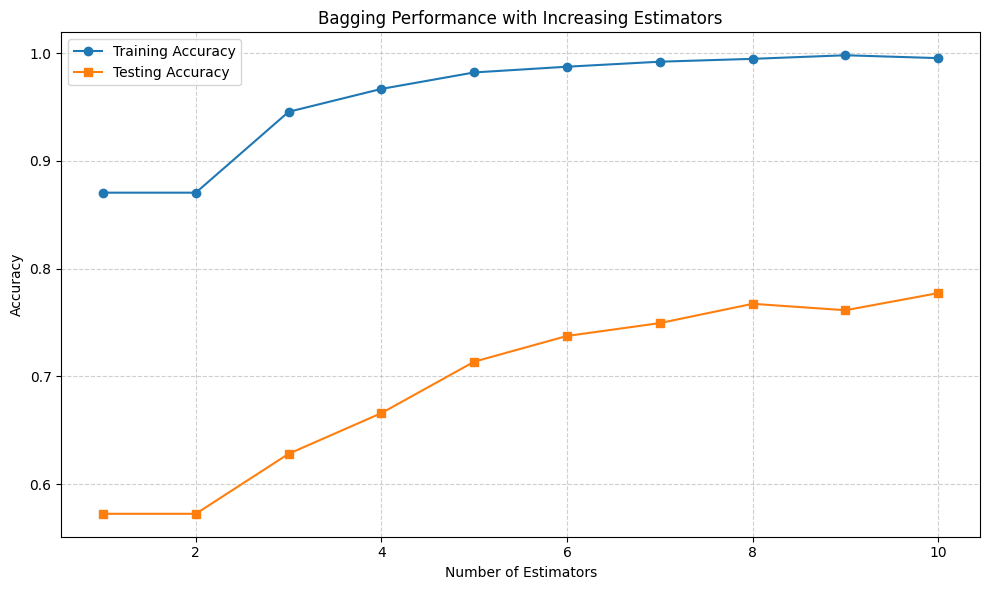

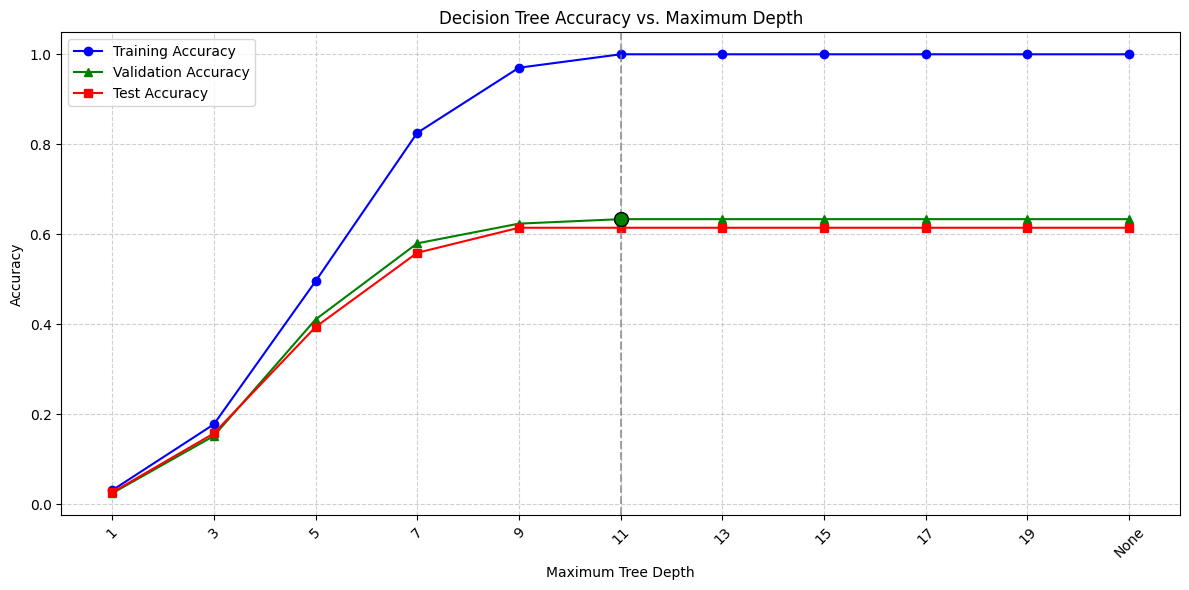


Training final decision tree with optimal depth...

--- Final Model Performance ---
Validation accuracy: 0.6335
Test accuracy: 0.6143
Weighted precision: 0.6444
Weighted recall: 0.6143
Weighted F1 score: 0.6153


<Figure size 2500x2500 with 0 Axes>

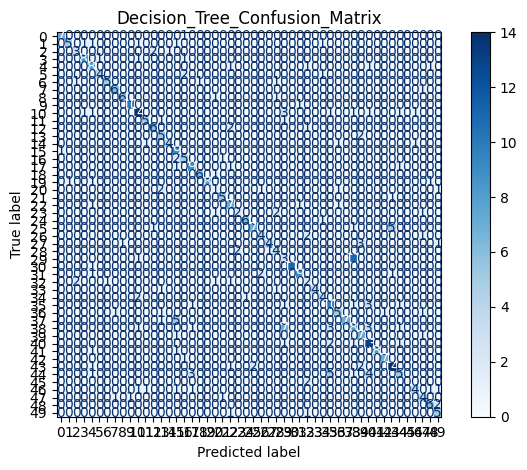


Total execution time: 331.44 seconds

Analysis complete.
Visualizations displayed inline.


In [15]:
if __name__ == "__main__":
    main()

In [16]:
# Example usage of ensemble methods
print("\n--- Ensemble Methods Testing ---")
bagging_decision_trees(X_train_enhanced, y_train, X_test_enhanced, y_test)


--- Ensemble Methods Testing ---


NameError: name 'X_train_enhanced' is not defined